<h1 style="color:orange">QDA Exam - Feb 2024</h1> 
Francesco Marco Riboli - 10502512 - 8CFU

# Exercise 2

A German company operating in the aerospace sector needs to monitor the manufacturing process for a new 
type  of  titanium  bracket.  The  quality  characteristic  of  interest  is  the  Brinell  hardness.  Four  hardness 
measurements are performed in four pre-defined locations of the component, and parts are randomly picked 
up from the shop floor and inspected every two hours. Data to be used for control chart design are reported in 
the  file  `AERO_phase1.csv`.  Each  column  refers  to  one  location  where  the  hardness  measurement  is 
performed. Assume the measurements within each sample were performed following the same order shown in 
the provided table.

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
from statsmodels.tsa.arima.model import ARIMA
import itertools
import statsmodels.graphics.tsaplots as sgt
from statsmodels.sandbox.stats.runs import runstest_1samp

,Close_Price
0,85.5065
1,85.6883
2,85.5325
3,86.7532
4,86.6494


## a) Check the assumptions and discuss the result (EDA)

In [190]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = pd.read_csv('AERO_phase1.csv')

# Inspect the dataset
data.head()


,loc1,loc2,loc3,loc4
0,337.4836,327.9231,336.7889,350.8550
1,334.3087,332.8968,337.8039,352.1991
2,338.2384,333.2864,340.4153,358.7365
3,342.6151,330.9886,340.2690,358.0519
4,333.8292,334.1936,328.1117,354.8955


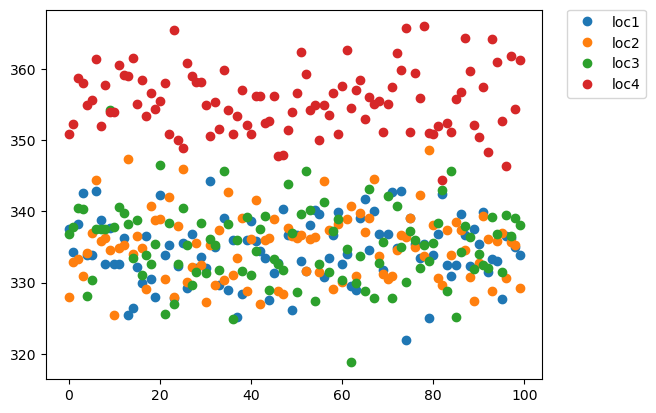

In [191]:
# Make a scatter plot of all the columns against the index
plt.plot(data['loc1'], linestyle='none', marker='o', label = 'loc1')
plt.plot(data['loc2'], linestyle='none', marker='o', label = 'loc2')
plt.plot(data['loc3'], linestyle='none', marker='o', label = 'loc3')
plt.plot(data['loc4'], linestyle='none', marker='o', label = 'loc4')

# place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

It seems the average value of loc4 is systematically higher than the one in the other locations

p-value of the Shapiro-Wilk test: 0.000


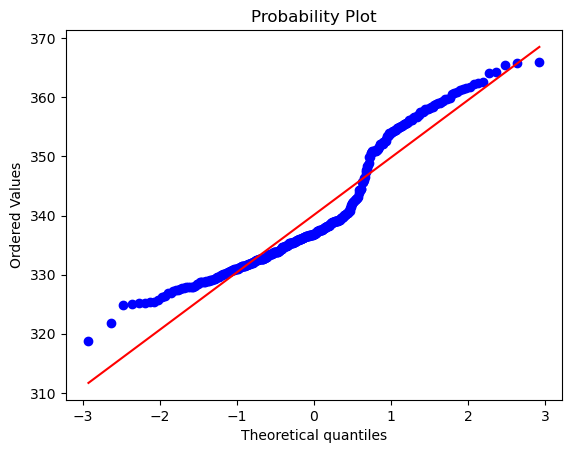

In [192]:
# Stack the data into a single column
data_stack = data.stack()

# We can use the Shapiro-Wilk test
_, p_value_SW = stats.shapiro(data_stack)
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_stack, dist="norm", plot=plt)
plt.show()

SW test p-value is lower than 0.05, so the data is not normal. Let's also check for Auto-Correlation

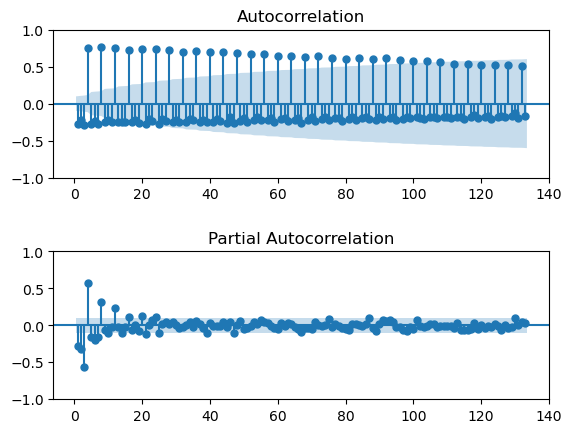

In [193]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data_stack, lags = int(len(data_stack)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data_stack, lags = int(len(data_stack)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

The plots reflects the systematic pattern affecting location 4.

## b) Design a statistical test to check if the hardness in location 4  is statistically higher than the hardness in location 2. Discuss the result. PAIRED T-TEST application

In [194]:
t0_stats_trel, p_value_t0_stats_trel = stats.ttest_rel(data['loc4'], data['loc2'], alternative='greater')
print('t-statistic from stats.ttest_rel: %.3f' % t0_stats_trel)
print('p-value from stats.ttest_rel: %.3f' % p_value_t0_stats_trel)

t-statistic from stats.ttest_rel: 31.137
p-value from stats.ttest_rel: 0.000


The paired t-test p-value demonstrates that the mean of loc4 is significantly higher than the mean of loc2

## c) Design a suitable univariate control charting method for these data, using K = 3.  In case of violation of control limits, assume no assignable cause is known

Due to the violation of the normality assumption caused by the statistically different hardness in location one, 
the most suitable approach would consist of fitting a model with a dummy regressor, and design a control chart 
for the residuals of the model. The dummy variable can be defined such that its value is 1 for location 1 and 0 
for all other locations.

In [195]:
# Add dummy variable
data_stack_dum = data.stack().reset_index()
data_stack_dum.columns = ['Index', 'Location', 'Value']
data_stack_dum['From_loc4'] = (data_stack_dum['Location'] == 'loc4').astype(int)

data_stack_dum.head()

,Index,Location,Value,From_loc4
0,0,loc1,337.4836,0
1,0,loc2,327.9231,0
2,0,loc3,336.7889,0
3,0,loc4,350.8550,1
4,1,loc1,334.3087,0


In [196]:
# Calculate a regression model with constant and dummy
import statsmodels.api as sm

x = data_stack_dum[["From_loc4"]]

# Add a constant to the model.
x = sm.add_constant(x) 

y = data_stack_dum['Value']
model = sm.OLS(y, x).fit()

# Print out the statistics
import qda
qda.summary(model)

REGRESSION EQUATION
-------------------
Value =  + 334.972 const + 20.562 From_loc4

COEFFICIENTS
------------
     Term     Coef  SE Coef   T-Value     P-Value
    const 334.9723   0.2772 1208.3851  0.0000e+00
From_loc4  20.5619   0.5544   37.0878 3.2795e-131

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
4.8014 0.7756      0.775

ANALYSIS OF VARIANCE
---------------------
    Source    DF     Adj SS     Adj MS    F-Value     P-Value
Regression   1.0 3.1710e+04 3.1710e+04 1.3755e+03 3.2795e-131
     const   1.0 3.3662e+07 3.3662e+07 1.4602e+06  0.0000e+00
 From_loc4   1.0 3.1710e+04 3.1710e+04 1.3755e+03 3.2795e-131
     Error 398.0 9.1751e+03 2.3053e+01        NaN         NaN
     Total 399.0 4.0885e+04        NaN        NaN         NaN


Shapiro-Wilk test p-value on the residuals = 0.333


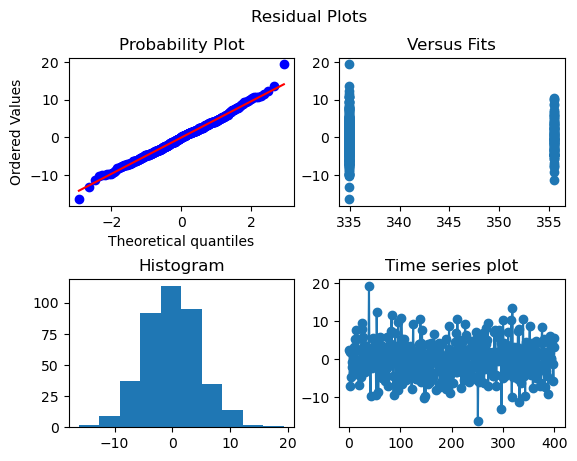

In [197]:
#NORMALITY OF RESIDUALS (PHASE 2)
residuals=model.resid
fitted=model.fittedvalues

fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(residuals, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(fitted, residuals)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(residuals)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')

_, pval_SW_res = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.422


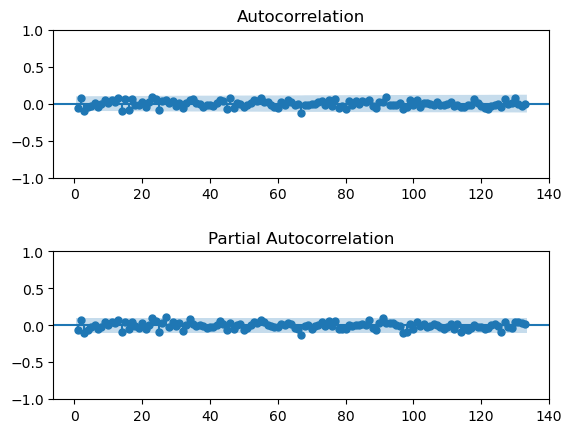

In [198]:
#RANDOMNESS OF RESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(residuals)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(residuals)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> Residuals do not show autocorrelation. Assumption on randomness of residuals is accepted.

We can move on by deifining the I-MR control chart of the new dataset

In [199]:
print(type(residuals))

<class 'pandas.core.series.Series'>


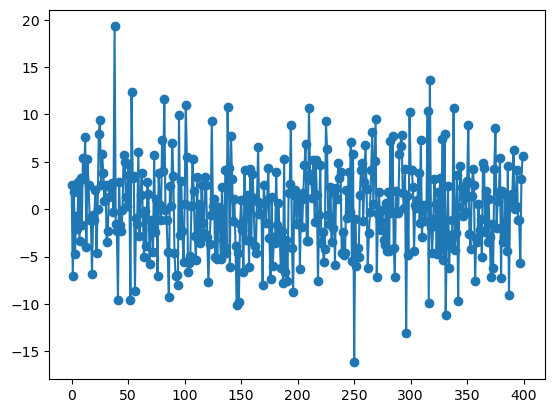

<class 'pandas.core.frame.DataFrame'>


In [200]:
# Convert residuals to DataFrame

#residuals_df = residuals.to_frame()
residuals_df=pd.DataFrame(residuals, columns=['residuals'])

# Plot the data
plt.plot(residuals_df['residuals'], 'o-')
plt.show()
print(type(residuals_df))

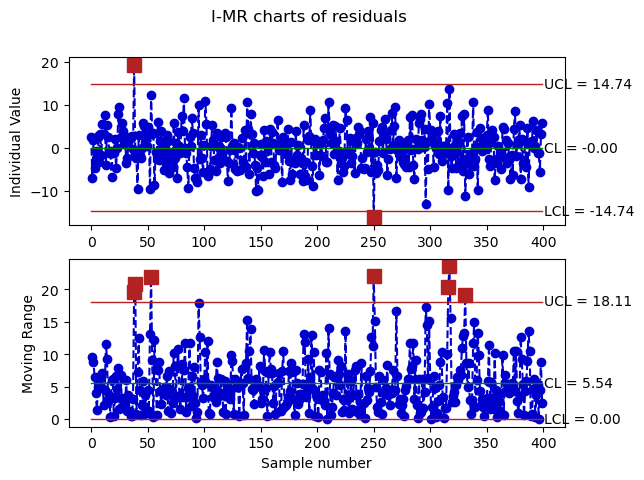

,residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
0,2.5113,NaN,14.7368,-2.6787e-13,-14.7368,NaN,18.1061,5.5429,0,NaN
1,-7.0491,9.5604,14.7368,-2.6787e-13,-14.7368,NaN,18.1061,5.5429,0,NaN
2,1.8167,8.8658,14.7368,-2.6787e-13,-14.7368,NaN,18.1061,5.5429,0,NaN
3,-4.6792,6.4959,14.7368,-2.6787e-13,-14.7368,NaN,18.1061,5.5429,0,NaN
4,-0.6636,4.0156,14.7368,-2.6787e-13,-14.7368,NaN,18.1061,5.5429,0,NaN


In [201]:
import qda
k=3 # given in the exercise
data_IMR = qda.ControlCharts.IMR(residuals_df,'residuals',k)
data_IMR.head()

There  is  two  violations  of  control  limits  in  the  I  chart  and  seven  violations  in  the  MR  chart.  Assuming  no 
assignable cause for them, the control chart design is over.

## d) Using  the  control  chart  designed  in  point  3)  determine  if  the  new  Brinell  hardness  measurements  in `AERO_phase2.csv` are in control or not. Discuss the result

Firstly, we need to preprocess the data as we did in phase 1

In [202]:
# load data
new_data=pd.read_csv('AERO_phase2.csv')

# Add dummy variable and stack
new_data_stack_dum = new_data.stack().reset_index()
new_data_stack_dum.columns = ['Index', 'Location', 'Value']
new_data_stack_dum['From_loc4'] = (new_data_stack_dum['Location'] == 'loc4').astype(int)

new_data_stack_dum.head()

,Index,Location,Value,From_loc4
0,0,loc1,337.4836,0
1,0,loc2,327.9231,0
2,0,loc3,336.7889,0
3,0,loc4,350.8550,1
4,1,loc1,334.3087,0


In [203]:
def apply_model_and_calculate_phase2_residuals(model_phase1, data_phase1, data_phase2, dependent_variable):

    # Extract predictors from the model
    predictors = model_phase1.params.index.tolist()
    #print(predictors)

    # Combine the datasets
    data_combined = data_phase1.append(data_phase2).reset_index(drop=True)
    #print(data_combined.describe())

    # Prepare the combined dataset for prediction
    X_combined = data_combined[predictors[1:]]  # Exclude the constant term from the predictors array

    X_combined = sm.add_constant(X_combined)  # Add a constant to the model

    # Extract model coefficients
    coefficients = model_phase1.params

    # Calculate the predicted values for the combined dataset
    predicted_combined = X_combined @ coefficients

    # Define the dependent variable for the combined dataset
    y_combined = data_combined[dependent_variable]

    # Calculate residuals
    residuals_combined = y_combined - predicted_combined
    
    return residuals_combined, predicted_combined


In [204]:
residuals_combined, predicted_combined = apply_model_and_calculate_phase2_residuals(model, data_stack_dum, new_data_stack_dum, 'Value')

In [205]:
print(type(residuals_combined))
residuals_combined.describe()

<class 'pandas.core.series.Series'>


count    520.0000
mean       0.0890
std        4.8235
min      -16.1786
25%       -3.3351
50%        0.0858
75%        3.1812
max       19.2914
dtype: float64

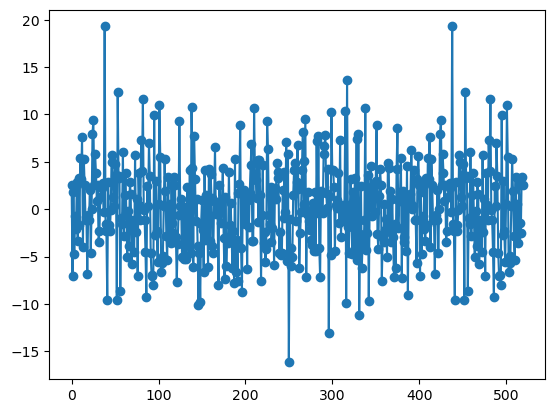

<class 'pandas.core.frame.DataFrame'>


,residuals
count,520.0000
mean,0.0890
std,4.8235
min,-16.1786
25%,-3.3351
50%,0.0858
75%,3.1812
max,19.2914


In [206]:
# Convert residuals to DataFrame

#residuals_df = residuals.to_frame()
residuals_combined_df=pd.DataFrame(residuals_combined, columns=['residuals'])

# Plot the data
plt.plot(residuals_combined_df['residuals'], 'o-')
plt.show()
print(type(residuals_combined_df))
residuals_combined_df.describe()

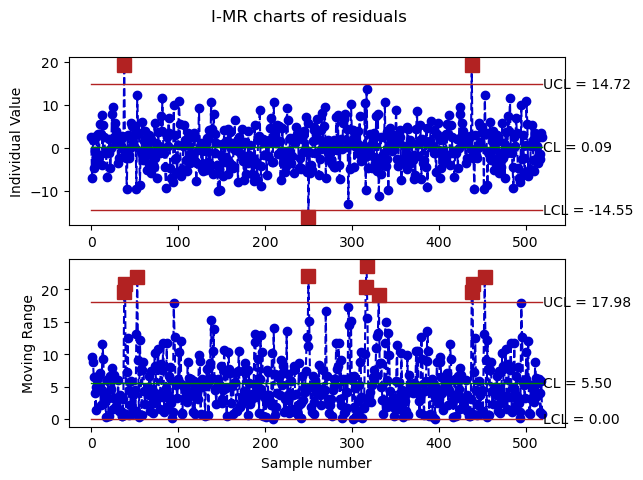

,residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
0,2.5113,NaN,14.724,0.089,-14.5459,NaN,17.9809,5.5046,0,NaN
1,-7.0491,9.5604,14.724,0.089,-14.5459,NaN,17.9809,5.5046,0,NaN
2,1.8167,8.8658,14.724,0.089,-14.5459,NaN,17.9809,5.5046,0,NaN
3,-4.6792,6.4959,14.724,0.089,-14.5459,NaN,17.9809,5.5046,0,NaN
4,-0.6636,4.0156,14.724,0.089,-14.5459,NaN,17.9809,5.5046,0,NaN


In [207]:
import qda
k=3 # given in the exercise
data_IMR = qda.ControlCharts.IMR(residuals_combined_df,'residuals',k)
data_IMR.head()

The additional datapoints show some OC points in both I and MR charts